# Make Simulated Neurons

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import sys
import tifffile as tf

sys.path.append('../')
from data_prep import generate, draw, load

## Generate simulated SWC file data.
This is a list of nodes, each node being a list:
[sample_idx, structure_id, x, y, z, radius, parent_id]

In [3]:
swc_list = generate.make_swc_list((101,101,101),
                        length=20,
                        step_size=3,
                        kappa=20.0,
                        uniform_len=False,
                        random_start=True,
                        rng=None,
                        num_branches=1) # make simulated neuron paths.

Set random background and foreground (neuron) colors

In [4]:
random_contrast=True
if random_contrast:
    neuron_color = np.random.rand(3)
    neuron_color /= np.linalg.norm(neuron_color)
    background = np.random.rand(3)
    background = background / np.linalg.norm(background) * 0.01

Draw neurons from SWC format data; one without and one with added noise and artifacts.

In [5]:
neuron_no_artifacts = draw.neuron_from_swc(swc_list,
                                width=3,
                                noise=0.0,
                                adjust=False,
                                neuron_color=None,
                                background_color=None,
                                random_brightness=False,
                                dropout=False,
                                binary=False)

neuron_with_artifacts = draw.neuron_from_swc(swc_list,
                                width=3,
                                noise=0.05,
                                adjust=False,
                                neuron_color=neuron_color,
                                background_color=background,
                                random_brightness=True,
                                dropout=True,
                                binary=False)



## Draw the images.
    a. Without artifacts

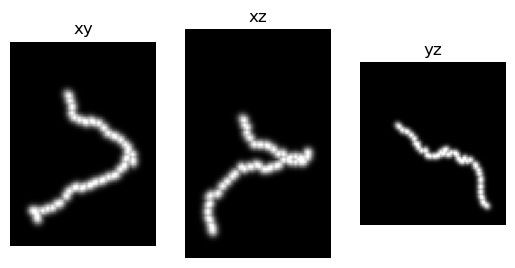

In [17]:
img = neuron_no_artifacts["image"].data.permute(1,2,3,0)

fig, ax = plt.subplots(1,3)
ax[0].imshow(img.amax(0))
ax[0].set_title('xy')
ax[1].imshow(img.amax(1))
ax[1].set_title('xz')
ax[2].imshow(img.amax(2))
ax[2].set_title('yz')
for x in ax:
    x.set_axis_off()
plt.show()

    b. With artifacts

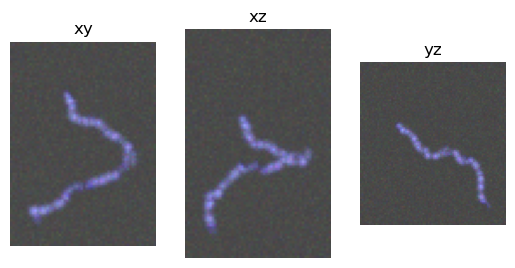

In [18]:
img = neuron_with_artifacts["image"].data.permute(1,2,3,0)

fig, ax = plt.subplots(1,3)
ax[0].imshow(img.amax(0))
ax[0].set_title('xy')
ax[1].imshow(img.amax(1))
ax[1].set_title('xz')
ax[2].imshow(img.amax(2))
ax[2].set_title('yz')
for x in ax:
    x.set_axis_off()
plt.show()

## Simulate from existing SWC file

### Load real neuron morphology data from an SWC file

In [8]:
labels_dir = "/home/brysongray/data/neuromorpho/"
files = [f for x in os.walk(labels_dir) for f in glob(os.path.join(x[0], '*.swc'))]

f_idx = 4
labels_file = files[f_idx]
# load and parse the SWC file data
swc_list = load.swc(labels_file)
sections, section_graph, branches, terminals, scale = load.parse_swc_list(swc_list, adjust=True)

loading file: /home/brysongray/data/neuromorpho/quinlan/CNG version/KQa4-12-2015-tracing.CNG.swc


In [84]:
# labels_file = "/home/brysongray/data/gold166/e_checked6_chick_uw/DONE_09-2902-04R-01C-60x_merge_c1/09-2902-04R-01C-60x_merge_c1.v3dpbd.swc"
labels_file = "/home/brysongray/data/gold166/e_checked6_chick_uw/DONE_case1-slide2-section1-left-cell1_merge_c2/case1-slide2-section1-left-cell1_merge_c2.v3dpbd.swc"
# load and parse the SWC file data
swc_list = load.swc(labels_file)
sections, sections_graph = load.parse_swc(swc_list)
branches, terminals = load.get_critical_points(swc_list, sections)

loading file: /home/brysongray/data/gold166/e_checked6_chick_uw/DONE_case1-slide2-section1-left-cell1_merge_c2/case1-slide2-section1-left-cell1_merge_c2.v3dpbd.swc


### Plot SWC raw data

In [4]:
# Create a DataFrame for plotting
data = []
# Iterate through the sections dictionary
for section_id, section_data in sections.items():
    # flatten the section into one list of consecutive points instead of segments (point pairs)
    for i,segment in enumerate(section_data):
        point = segment[0] 
        data.append([section_id, point[0].item(), point[1].item(), point[2].item()])
        if i == len(section_data)-1:
            point = segment[1]
            data.append([section_id, point[0].item(), point[1].item(), point[2].item()])
df_sections = pd.DataFrame(data, columns=["section", "x", "y", "z"])

fig = px.line_3d(df_sections, x="x", y="y", z="z", color='section', )
fig.update_layout(scene_aspectmode='data')
fig.show()

In [23]:
# Create a DataFrame for plotting
data = []
# Iterate through the sections dictionary
for section_id, section_data in sections.items():
    # flatten the section into one list of consecutive points instead of segments (point pairs)
    for i,segment in enumerate(section_data):
        point = segment[0] 
        data.append([section_id, point[0].item(), point[1].item(), point[2].item()])
        if i == len(section_data)-1:
            point = segment[1]
            data.append([section_id, point[0].item(), point[1].item(), point[2].item()])
df_sections = pd.DataFrame(data, columns=["section", "x", "y", "z"])

fig = px.line_3d(df_sections, x="x", y="y", z="z", color='section', )
fig.update_layout(scene_aspectmode='data')
fig.show()

### Simulate a neuron microscopy image with artifacts from the SWC data

Set random colors for the background and foreground voxels. 

In [4]:
random_contrast = True

rng = np.random.default_rng()
neuron_color = np.array([1.0, 1.0, 1.0])
background = np.array([0., 0., 0.])
if random_contrast:
    neuron_color = rng.uniform(size=3)
    neuron_color /= np.linalg.norm(neuron_color)
    background_color = rng.uniform(size=3)
    background_color = background_color / np.linalg.norm(background_color) * 0.01

Draw the neuron image

In [5]:

swc_data = draw.neuron_from_swc(swc_list,
                                width=3,
                                noise=0.00,
                                dropout=False,
                                adjust=False,
                                background_color=background,
                                neuron_color=neuron_color,
                                random_brightness=False,
                                binary=False,
                                rng=rng)

Plot

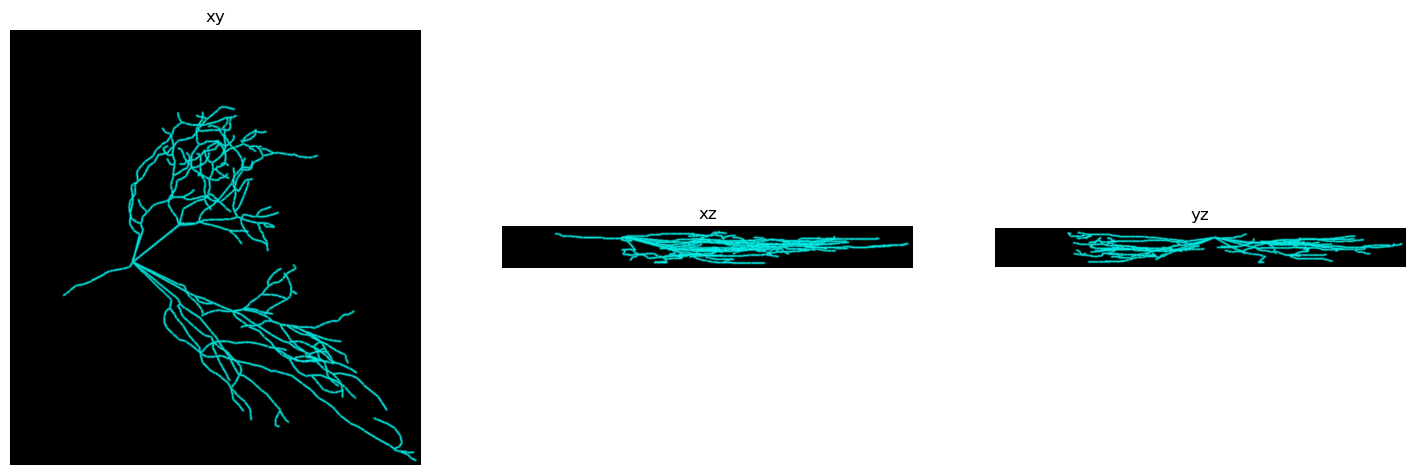

In [17]:
img = swc_data["image"].data.permute(1,2,3,0)

fig, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].imshow(img.amax(0))
ax[0].set_title('xy')
ax[1].imshow(img.amax(1))
ax[1].set_title('xz')
ax[2].imshow(img.amax(2))
ax[2].set_title('yz')
for x in ax:
    x.set_axis_off()
plt.show()

In [86]:

img_path = "/home/brysongray/data/gold166_tifs/case1-slide2-section1-left-cell1_merge_c2.tif"
img = tf.imread(img_path)
shape = img.shape
# del img

sections, sections_graph = load.parse_swc(swc_list)
branches, terminals = load.get_critical_points(swc_list, sections)

segments = []
for section in sections.values():
    segments.append(section)
segments = np.concatenate(segments)

density = draw.draw_neuron_density(segments, shape)

/home/brysongray/neurotrack/notebooks/../data_prep/image.py:204: UserWarning: Center tensor([ 78.0350, 603.8480, 556.5220], dtype=torch.float64) is out of bounds for image shape torch.Size([76, 1024, 1024]). Translating to the nearest valid index.
  warnings.warn(f"Center {center} is out of bounds for image shape {shape}. Translating to the nearest valid index.")
/home/brysongray/neurotrack/notebooks/../data_prep/image.py:204: UserWarning: Center tensor([ 78.0350, 598.4050, 528.3160], dtype=torch.float64) is out of bounds for image shape torch.Size([76, 1024, 1024]). Translating to the nearest valid index.
  warnings.warn(f"Center {center} is out of bounds for image shape {shape}. Translating to the nearest valid index.")
/home/brysongray/neurotrack/notebooks/../data_prep/image.py:204: UserWarning: Center tensor([ 78.0350, 594.4450, 517.9240], dtype=torch.float64) is out of bounds for image shape torch.Size([76, 1024, 1024]). Translating to the nearest valid index.
  warnings.warn(f"Ce

In [94]:
to_remove = {}
for i in range(len(labels_files)):
    swc_file = labels_files[i]
    # load and parse the SWC file data
    swc_list = load.swc(os.path.join(labels_dir, swc_file))
    sections, sections_graph = load.parse_swc(swc_list)
    segments = []
    for section in sections.values():
        segments.append(section)
    segments = np.concatenate(segments)
    if segments.max(axis=(0,1))[3] <= 1.0:
        # print(i, swc_file)
        to_remove[i] = swc_file

loading file: /home/brysongray/data/gold166_swc_scaled/140921c16.tif.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/1201_01_s06b_L36_Sum_ch2.tif.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/Image31.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/GMR_57C10_AD_01-1xLwt_attp40_4stop1-m-A02-20111101_2_E2-right_optic_lobe.v3draw.extract_3.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A1-right_optic_lobe.v3draw.extract_5.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/0661_seg.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/09-2902-04R-01C-60x_merge_c1.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/neuron4.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/6_1_Live_2-2-2010_11-05-38_AM_med_Red.tif_uint8.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/ILP_PN_neuron.v3dpbd.swc
l

In [95]:
for key, value in to_remove.items():
    print(key, value)

1 1201_01_s06b_L36_Sum_ch2.tif.v3dpbd.swc
8 6_1_Live_2-2-2010_11-05-38_AM_med_Red.tif_uint8.v3dpbd.swc
12 1_2_Ch2.tif_uint8.v3dpbd.swc
16 1_1_Live_2-2-2010_9-52-24_AM_med_Red.tif_uint8.v3dpbd.swc
45 slice12_4to51_ch2.tif.v3dpbd.neuron1.swc
61 1_10_Ch2.tif_uint8.v3dpbd.swc
75 120111_05new_ch2.tif.v3dpbd.neuron1.swc
86 10-2909-s5-left-cell3_merge_c2.v3dpbd.swc
97 slice12_4to51_ch2.tif.v3dpbd.neuron2.swc
104 case1-slide2-section1-left-cell1_merge_c2.v3dpbd.swc
107 10-2912-s1-cell1_merge_c2.v3dpbd.swc
115 10_3dpf_Live_1-28-2010_5-20-37_PM_med_Red.tif_uint8.v3dpbd.swc
131 1_9_Ch2.tif_uint8.v3dpbd.swc
133 12_3dpf_Live_1-28-2010_5-47-24_PM_med_Red.tif_uint8.v3dpbd.swc


In [97]:
import os
import shutil

# move files in to_remove to different folder
# Create a destination folder for files with small radius
labels_dir = "/home/brysongray/data/gold166_swc_scaled/"
img_dir = os.path.expanduser("~/data/gold166_tifs_scaled/")
dest_dir = "/home/brysongray/data/gold166_swc_scaled_removed/"
img_files = os.listdir(img_dir)
img_dest_dir = "/home/brysongray/data/gold166_tifs_scaled_removed/"

# Move files from to_remove dictionary to the destination folder
for idx, filename in to_remove.items():
    source_path = os.path.join(labels_dir, filename)
    dest_path = os.path.join(dest_dir, filename)
    img_name = [f for f in img_files if f.split(".")[0] in filename][0]
    img_source_path = os.path.join(img_dir, img_name)
    img_dest_path = os.path.join(img_dest_dir, img_name)
    
    # Check if the source file exists
    if os.path.exists(source_path):
        # Move the file
        shutil.move(source_path, dest_path)
        print(f"Moved file {idx}: {filename}")
    else:
        print(f"File not found: {source_path}")
    if os.path.exists(img_source_path):
        shutil.move(img_source_path, img_dest_path)
        print(f"Moved file {img_name}")
    else:
        print(f"File not found: {img_name}")

print(f"Moved {len(to_remove)} files to {dest_dir}")

File not found: /home/brysongray/data/gold166_swc_scaled/1201_01_s06b_L36_Sum_ch2.tif.v3dpbd.swc
Moved file 1201_01_s06b_L36_Sum_ch2.tif
File not found: /home/brysongray/data/gold166_swc_scaled/6_1_Live_2-2-2010_11-05-38_AM_med_Red.tif_uint8.v3dpbd.swc
Moved file 6_1_Live_2-2-2010_11-05-38_AM_med_Red.tif
File not found: /home/brysongray/data/gold166_swc_scaled/1_2_Ch2.tif_uint8.v3dpbd.swc
Moved file 1_2_Ch2.tif
File not found: /home/brysongray/data/gold166_swc_scaled/1_1_Live_2-2-2010_9-52-24_AM_med_Red.tif_uint8.v3dpbd.swc
Moved file 1_1_Live_2-2-2010_9-52-24_AM_med_Red.tif
File not found: /home/brysongray/data/gold166_swc_scaled/slice12_4to51_ch2.tif.v3dpbd.neuron1.swc
Moved file slice12_4to51_ch2.tif
File not found: /home/brysongray/data/gold166_swc_scaled/1_10_Ch2.tif_uint8.v3dpbd.swc
Moved file 1_10_Ch2.tif
File not found: /home/brysongray/data/gold166_swc_scaled/120111_05new_ch2.tif.v3dpbd.neuron1.swc
Moved file 120111_05new_ch2.tif
File not found: /home/brysongray/data/gold166_s

In [115]:
# labels_file = "/home/brysongray/data/gold166/e_checked6_chick_uw/DONE_case1-slide2-section1-left-cell1_merge_c2/case1-slide2-section1-left-cell1_merge_c2.v3dpbd.swc"
labels_dir = "/home/brysongray/data/gold166_swc_scaled/"
img_dir = os.path.expanduser("~/data/gold166_tifs_scaled/")
labels_files = os.listdir(labels_dir)
labels_files = sorted(labels_files)
img_files = os.listdir(img_dir)
img_files = sorted(img_files)
# for i in range(len(labels_files)):
i = 22
swc_file = labels_files[i]
img_file = [f for f in img_files if f.split('.')[0] in swc_file][0]
print(i, f"swc file: {swc_file}")
print(f"image file: {img_file}")

# load and parse the SWC file data
swc_list = load.swc(os.path.join(labels_dir, swc_file))
sections, sections_graph = load.parse_swc(swc_list)
branches, terminals = load.get_critical_points(swc_list, sections)
segments = []
for section in sections.values():
    segments.append(section)
segments = np.concatenate(segments)
print(segments.max(axis=(0,1))[3])

img = tf.imread(os.path.join(img_dir, img_file))
shape = img.shape
density = draw.draw_neuron_density(segments, shape)

22 swc file: 140921c12.tif.v3dpbd.swc
image file: 140921c1.tif
loading file: /home/brysongray/data/gold166_swc_scaled/140921c12.tif.v3dpbd.swc
20.0


/home/brysongray/neurotrack/notebooks/../data_prep/image.py:204: UserWarning: Center tensor([124.2633, 505.3530,   9.4652], dtype=torch.float64) is out of bounds for image shape torch.Size([112, 1600, 1600]). Translating to the nearest valid index.
  warnings.warn(f"Center {center} is out of bounds for image shape {shape}. Translating to the nearest valid index.")
/home/brysongray/neurotrack/notebooks/../data_prep/image.py:204: UserWarning: Center tensor([127.7915, 503.3800,  14.1642], dtype=torch.float64) is out of bounds for image shape torch.Size([112, 1600, 1600]). Translating to the nearest valid index.
  warnings.warn(f"Center {center} is out of bounds for image shape {shape}. Translating to the nearest valid index.")
/home/brysongray/neurotrack/notebooks/../data_prep/image.py:204: UserWarning: Center tensor([131.5894, 500.5740,  20.9347], dtype=torch.float64) is out of bounds for image shape torch.Size([112, 1600, 1600]). Translating to the nearest valid index.
  warnings.warn(f

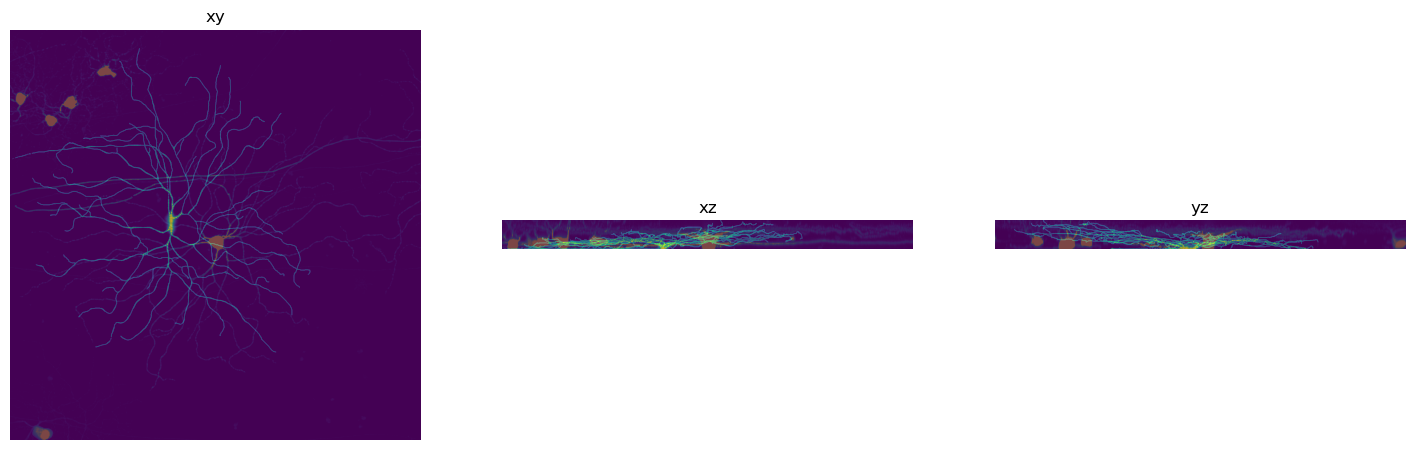

In [110]:
alpha = 0.7
fig, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].imshow(img.max(0))
ax[0].imshow(density.data[0].amax(0), alpha=alpha)
ax[0].set_title('xy')
ax[1].imshow(img.max(1))
ax[1].imshow(density.data[0].amax(1), alpha=alpha)
ax[1].set_title('xz')
ax[2].imshow(img.max(2))
ax[2].imshow(density.data[0].amax(2), alpha=alpha)
ax[2].set_title('yz')
for x in ax:
    x.set_axis_off()
plt.show()

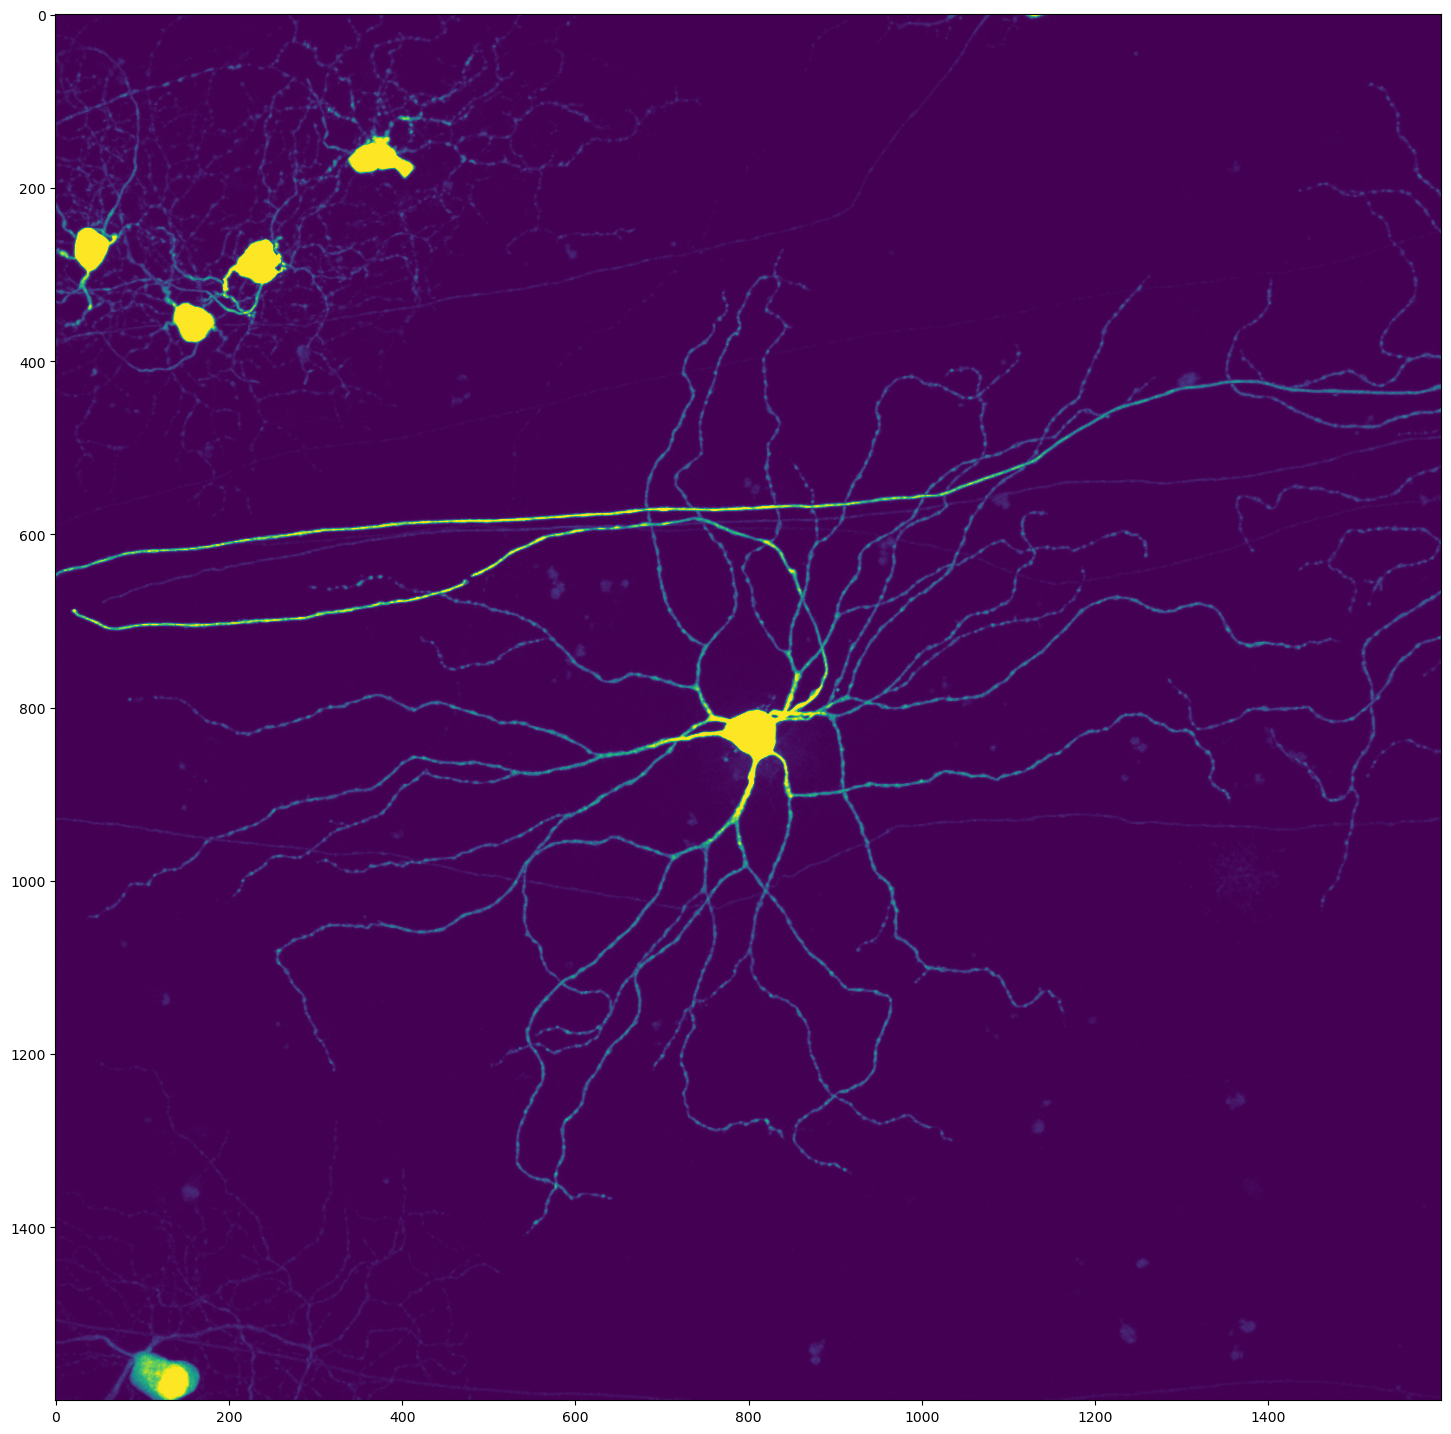

In [114]:
dim = 0
alpha=0.0
plt.figure(figsize=(18,18))
plt.imshow(img.max(dim))
plt.imshow(density.data[0].amax(dim), alpha=alpha)
